## Setups

In [16]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU usage
import mne
from scipy.signal import welch

import torch
import keras
from sklearn.manifold import TSNE
import json
from src.EEGModalNet.data.dataloader import LEMONEEGDataModule
from src.EEGModalNet.models.gan import SimpleGAN
from src.EEGModalNet.data.mock_temporal_data import MockTemporalData
from src.EEGModalNet.utils import ProgressBarCallback
from src.EEGModalNet.models.WGAN import WGAN_GP
from tqdm.auto import tqdm


# helper functions
def train_model(model, x, max_epochs, early_stopping=True, logger_dir='tmp/keras_logs/simple_gan_v1.csv', patience=100):
    reusable_pbar=tqdm(total=max_epochs, unit='epoch', leave=False, dynamic_ncols=True)
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                d_optimizer=keras.optimizers.Adam(0.001),
                g_optimizer=keras.optimizers.Adam(0.0001))
    
    callbacks = [keras.callbacks.CSVLogger(logger_dir),
                 ProgressBarCallback(n_epochs=max_epochs, n_runs=1, run_index=0, reusable_pbar=reusable_pbar)]
    if early_stopping:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='d_loss', mode='min', patience=patience))

    history = model.fit(
        x,
        epochs=max_epochs,
        verbose=0, # type: ignore
        shuffle=True,
        callbacks=callbacks
    )
    return history

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['d_loss'], label='discriminator')
    plt.plot(history.history['g_loss'], label='generator')
    plt.legend()
    plt.show()

def plot_step_losses(step_loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(step_loss_history.step_losses['d_loss'], label='discriminator')
    plt.plot(step_loss_history.step_losses['g_loss'], label='generator')
    plt.legend()
    plt.show()

sns.color_palette("viridis", as_cmap=True)
sns.set_style('darkgrid')

# Plotting helper functions
def plot_onebyone(x_gen, x, n_seg=5, ch=0, time_dim=512, start_from=0):
    for i in range(start_from, n_seg+start_from):
        plt.figure(figsize=(2*n_seg, n_seg//2))
        plt.plot(x_gen[i, :time_dim, ch], label='generated')
        plt.plot(x[i, :time_dim, ch], label='real')
        plt.xlim(0, time_dim)
        plt.legend()
        plt.show()

def plot_overlap(x, n_seg=5, ch=0, time_dim=512, start_from=0, show=True):
    plt.figure(figsize=(20, 2))
    for i in range(start_from, start_from+n_seg):
        plt.plot(x[i, :time_dim, ch])
    plt.xlim(0, time_dim)
    if show:
        plt.show()

def plot_psd(x, fmin=1, fmax=60, n_fft=512, label='real', show=True):
    psd, freq = mne.time_frequency.psd_array_welch(x.flatten(0, 1).permute(1, 0).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft)
    plt.plot(freq, 10*np.log10(psd.mean(0)), label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

def compare_psds(x, x_gen, lim=[20, 100], nperseg=2048, nfft=2048):
    f, Pxx = welch(x, fs=128, nperseg=nperseg, nfft=nfft)
    f_gen, Pxx_gen = welch(x_gen, fs=128, nperseg=nperseg, nfft=nfft)
    plt.plot(f[lim[0]:lim[1]], Pxx[lim[0]:lim[1]], label='real')
    plt.plot(f_gen[lim[0]:lim[1]], Pxx_gen[lim[0]:lim[1]], label='generated')
    plt.legend()
    plt.show()

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

def plot_tsne(x, x_gen):
    sample_len = x.shape[0]
    x_flat = x.mean(axis=2)
    x_flat_hat = x_gen.mean(axis=2)
      
    x_flat_final = np.concatenate((x_flat, x_flat_hat), axis = 0)
    tsne = TSNE(n_components=2, verbose=1, perplexity=20)
    tsne_results = tsne.fit_transform(x_flat_final)
        
    # Plotting
    f, ax = plt.subplots(1)
    colors = ["red" for i in range(sample_len)] + ["blue" for i in range(sample_len)]
        
    plt.scatter(tsne_results[:sample_len, 0], tsne_results[:sample_len,1], 
                c = colors[:sample_len], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[sample_len:, 0], tsne_results[sample_len:, 1], 
                c = colors[sample_len:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

def plot_psd4sujects(x, channels):
    """ Plot the power spectral density for different channels for each subjects """
    psd, freq = mne.time_frequency.psd_array_welch(x, sfreq=128, n_fft=128, fmax=60)
    for j in range(x.shape[0]):
        plt.figure(figsize=(10, 5))
        for i in range(x.shape[1]):
            plt.plot(freq, 10*np.log10(psd[j, i, :]))
        # stick the channel name to the corresponding line
        for i in range(61):
            plt.text(60, 10*np.log10(psd[j, i, -1]), channels[i], fontsize=8)
        plt.title(f'Subject {j}')
        plt.show()

def plot_psd4subjects_channel(xarray, n_subjects=20, ch_list=['O1'], fmin=1, fmax=64):
    sub_ids = xarray.subject[:n_subjects].to_numpy()
    x = xarray.sel(subject=xarray.subject[:n_subjects]).to_numpy()
    ch_ids = find_channel_ids(xarray, ch_list)
    x = x[:, ch_ids, 440:]
    psd, freq = mne.time_frequency.psd_array_welch(x, sfreq=128, fmin=1, fmax=64, n_fft=512)
    psd = 10*np.log10(psd.squeeze(1))
    for i in range(psd.shape[0]):
        plt.plot(freq, psd[i])
        # stick the channel name to the corresponding line
        for i in range(len(sub_ids)):
            plt.text(60, psd[i, -1], sub_ids[i], fontsize=8)
        plt.xlabel('Frequency (Hz)')

def plot_raw4subject_channel(xarray, sub=0, chann_list=['O1'], start=0, filter=True, filter_range=[1, 60]):
    if isinstance(sub, int):
        x = xarray.sel(subject=xarray.subject[sub]).to_numpy()
    else:
        x = xarray.sel(subject=sub).to_numpy()
    idx = find_channel_ids(xarray, chann_list)
    x = x[idx, :]
    if filter:
        x = mne.filter.filter_data(x, 128, filter_range[0], filter_range[1], method='fir', verbose=False)  # filter data
    x = torch.tensor(x).unsqueeze(0)
    x = x.unfold(2, 512, 512).permute(0, 2, 3, 1).flatten(0, 1)
    plot_overlap(x, start_from=start)

def save_step_losses(step_losses, filename='step_losses.json'):
    with open(filename, 'w') as f:
        json.dump(step_losses, f)

# Custom Callbacks
# callback to log losses at each step
class StepLossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.step_losses = {'g_loss': [], 'd_loss': []}

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.step_losses['g_loss'].append(logs.get('g_loss'))
        self.step_losses['d_loss'].append(logs.get('d_loss'))

## DATA

In [36]:
# 1. DATA
import numpy as np
from pathlib import Path
data_path = 'data/LEMON_data/EEG_Preprocessed/'

channel = 'Oz'
processed = False
filtering = True
time_dim = 1024
n_subject = 30

if processed:
    data_ec = {}

    # read epochs data with mne
    for i in Path(data_path).glob('sub-01000*_EC.set'):
        sub_id = i.stem
        raw_ec = mne.io.read_raw_eeglab(i, verbose=False)
        if channel in raw_ec.ch_names:
            raw_ec = raw_ec.pick([channel]).get_data()
            data_ec[sub_id] = raw_ec

    data = {k: torch.tensor(v).unfold(1, time_dim, time_dim).permute(1, 2, 0) for k, v in data_ec.items()}
    del data_ec

    # create sub_ids
    sub_ids = np.array([]).astype(int)
    for i, k in enumerate(data.keys()):
        sub_ids = np.concatenate((sub_ids, np.array([int(i)]*data[k].shape[0], dtype=int)), dtype=int)

    sub_ids = sub_ids[:, np.newaxis]

    # sanity check
    print(np.unique(sub_ids, return_counts=True))

    x = np.zeros([1, time_dim, 1])
    for k in data.keys():
        x = np.concatenate((x, data[k]), axis=0)
    x = x[1:]
    data = {'x': x, 'sub': sub_ids}

else:
    # data
    data_path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
    xarray = xr.open_dataarray(data_path, engine='h5netcdf')

    x = xarray.sel(subject=xarray.subject[:n_subject]).to_numpy()
    # ch_list = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'Fz', 'Cz', 'Pz', 'Oz', 'F7', 'F8']
    ch_list = [channel]
    ch_ids = find_channel_ids(xarray, ch_list)
    x = x[:, ch_ids, 440:]
    if filtering:
        x = mne.filter.filter_data(x, 128, 1, None, method='fir', verbose=False)  # filter data
    x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
    sub = np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis]
    data = {'x': x, 'sub': sub}

Effective window size : 4.000 (s)
(30, 253)


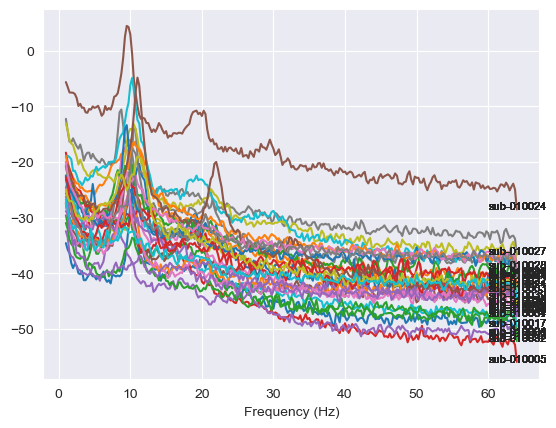

In [45]:
# make sure the PSD of the data across all the recordings is in the right shape
plot_psd4subjects_channel(xarray, n_subjects=30, ch_list=[channel], fmin=1, fmax=64)

## TRAINING

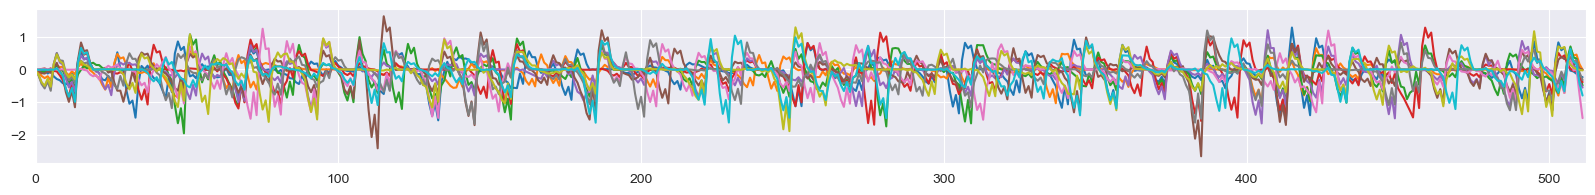

In [14]:
# 2. MODEL and Plot generated data by the model before training
latent_dim = 64
wgan_gp = WGAN_GP(time_dim=time_dim, feature_dim=1, latent_dim=latent_dim, n_subjects=n_subject, use_sublayer_generator=True)
x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps')).cpu().detach()
plot_overlap(x_gen, n_seg=10, start_from=20)
# wgan_gp.generator.summary()

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


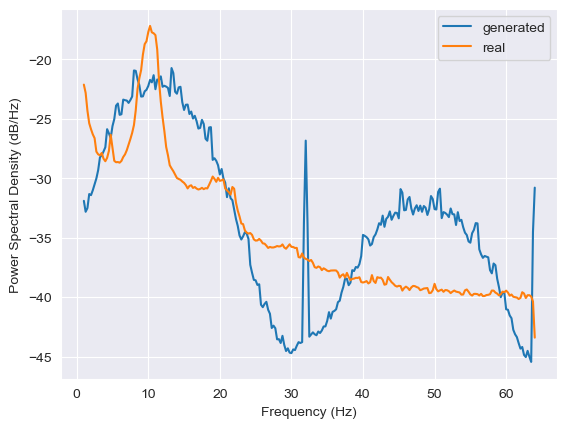

In [15]:
plot_psd(x_gen, fmin=1, fmax=200, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, fmax=200, n_fft=512, label='real', show=True)
plt.show()

In [16]:
torch.cuda.empty_cache() # clear GPU memory before training
step_loss_history = StepLossHistory()

# 3. TRAINING
wgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
                g_optimizer=keras.optimizers.Adam(0.001, beta_1=0.5, beta_2=0.9),
                gradient_penalty_weight=1.0)

# early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='g_loss', mode='min', patience=500)

In [23]:
# training
history = wgan_gp.fit(data, epochs=50, batch_size=64, callbacks=[step_loss_history, early_stopping], shuffle=True)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - d_loss: -0.0726 - g_loss: -0.4529
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - d_loss: -0.1023 - g_loss: -1.3584
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - d_loss: 0.0782 - g_loss: -1.5680
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - d_loss: -0.0243 - g_loss: -0.1589
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - d_loss: -0.0784 - g_loss: -0.5128
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - d_loss: -0.1829 - g_loss: -1.4621
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - d_loss: -0.1571 - g_loss: -1.1248
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - d_loss: -0.1277 - g_loss: -2.0842
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - d_loss: -0.1880 - g_loss: -1.8897
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - d_loss: -0.1798 - g_loss: -2.4390
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - d_loss: -0.2998 - g_loss: -2.4720
Epoch 12/50
28/28 ━━━━━━━━━━━━━

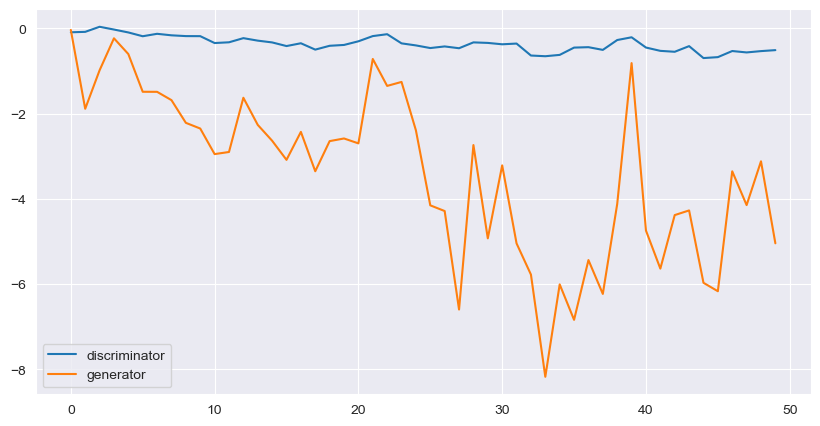

In [24]:
plot_history(history)

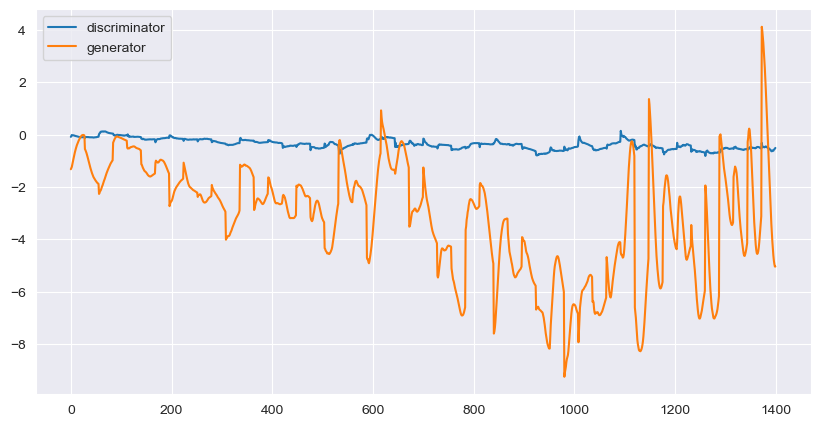

In [25]:
plot_step_losses(step_loss_history)
# save_step_losses(step_loss_history.step_losses, filename='tmp/keras_losses/step_losses.json')

## Evaluations & Visualisations

In [26]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
sigmoid(wgan_gp.critic(x_gen.float().to('mps'), torch.tensor(sub).to('mps')).mean().item()), sigmoid(wgan_gp.critic(x.float().to('mps'), torch.tensor(sub).to('mps')).mean().item())

(0.9960004342965467, 0.9964061191007652)

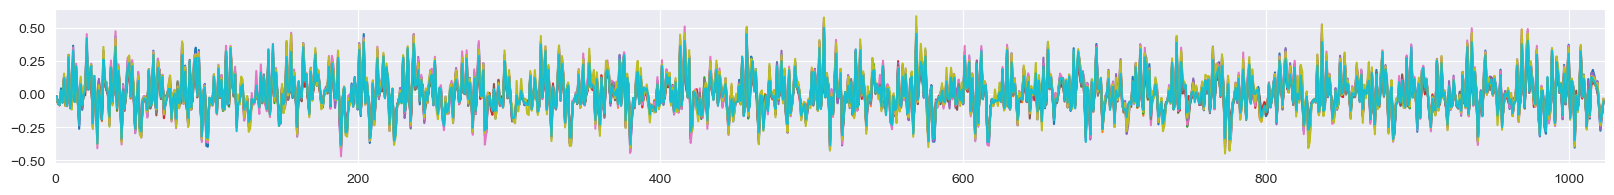

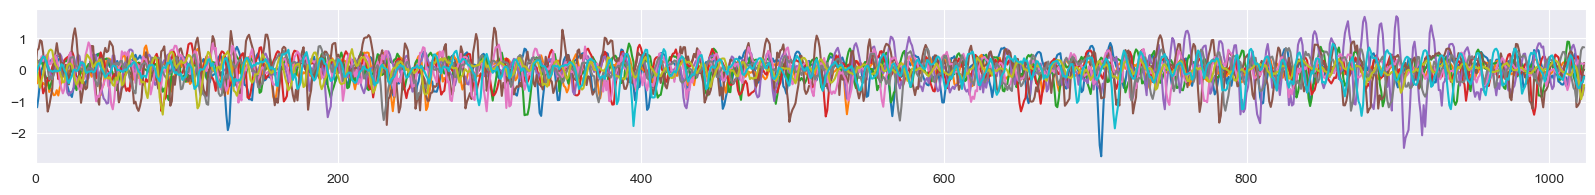

In [44]:
x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std()),
                          torch.tensor(sub).to('mps')).cpu().detach()
# x_gen = wgan_gp.generator.sub_layer(x_gen.to('mps'), torch.tensor(sub).to('mps')).cpu().detach()
plot_overlap(x_gen, n_seg=10, start_from=600, time_dim=1024, show=False)
plot_overlap(x, n_seg=10, start_from=600, time_dim=1024, show=False)
plt.show()


Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


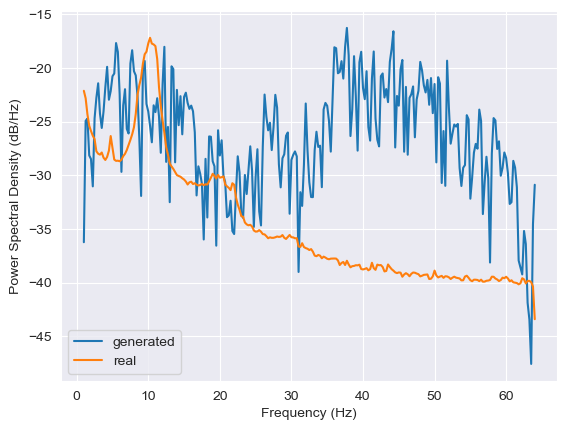

In [28]:
plot_psd(x_gen, fmin=1, fmax=200, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, fmax=200, n_fft=512, label='real', show=True)
plt.show()

## Visualize each layer of Critic's and Generator's output

### Generator

In [61]:
# helper functions for plotting
def plot_neurons_act(features, across_batch=False, from_to=(20, 40), batch=0, xlim=1024):
    plt.figure(figsize=(20, 2))
    if len(features.shape) == 3:
        if across_batch:
            for i in range(from_to[0], from_to[1]):
                plt.plot(features[i, :, 0])
        else:
            for i in range(0, features.shape[2]):
                plt.plot(features[batch, :, i])

    if len(features.shape) == 2:
        for i in range(from_to[0], from_to[1]):
            plt.plot(features[i, :])
    plt.xlim(0, xlim)
    plt.show()

outputs's shape: (1770, 1024, 1)


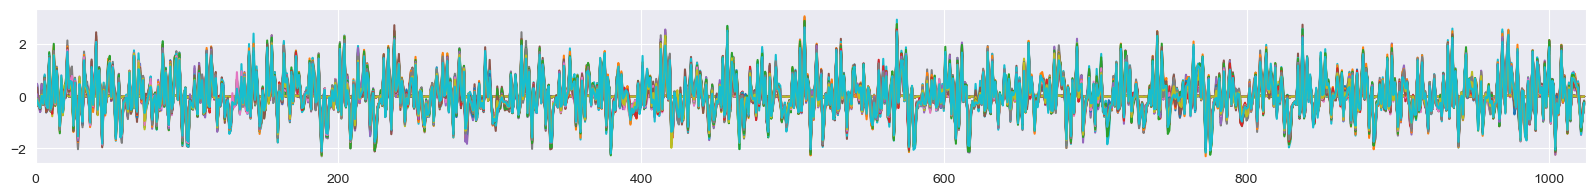

In [92]:
generator = wgan_gp.generator
out = keras.Model(generator.model.layers[0].input, generator.model.layers[-1].output)
features = out(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std()))
features = generator.sub_layer(features, torch.tensor(sub).to('mps')).cpu().detach().numpy()
print(f"outputs's shape: {features.shape}")
plot_neurons_act(features, across_batch=True, from_to=(0, 100), xlim=features.shape[1])

### Critic

outputs's shape: (1770, 1024, 8)


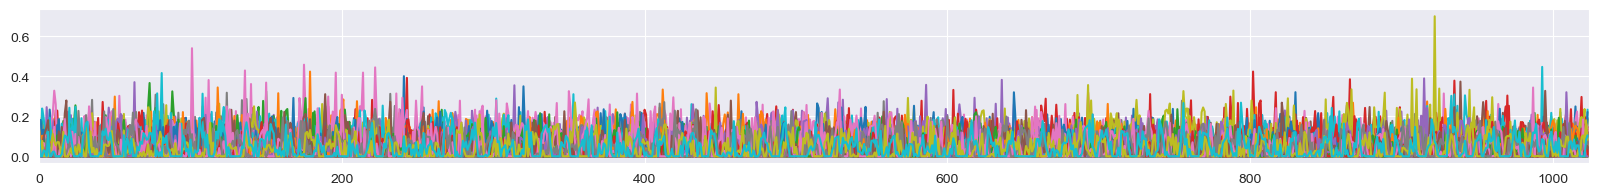

In [94]:
critic = wgan_gp.critic
model = keras.Model(inputs=critic.model.layers[0].input, outputs=critic.model.layers[0].output)
features = model(x.float()).cpu().detach().numpy()
print(f"outputs's shape: {features.shape}")
plot_neurons_act(features, across_batch=True, from_to=(0, 100), xlim=features.shape[1])

## Feature extraction

In [29]:
### Gender Classification
import torch
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, StratifiedShuffleSplit
from sklearn.feature_selection import VarianceThreshold

# helper functions
def open_data(path, sub=19, ch=27, seg_size=512):
    xarray = xr.open_dataarray(path, engine='h5netcdf')
    x = xarray.sel(subject=xarray.subject[sub]).to_numpy()
    x = x[ch, :]
    x = torch.tensor(x).unsqueeze(1).unfold(0, seg_size, seg_size).permute(0, 2, 1)
    return x

def take_ids(sub_ids):
    return np.array([int(i.split('-')[1][-3:]) for i in sub_ids.to_numpy()])

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

In [30]:
# open data and gender data
# gender classification
ch_list = ['O1']
time_dim = 1024
take_rnd = 10
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
f_ids = np.where(xarray.gender == 1)[0]
m_ids = np.where(xarray.gender == 2)[0]
ch_ids = find_channel_ids(xarray, ch_list)
# TODO set aside the first 20 subjects
f_ids = np.random.choice(f_ids, take_rnd, replace=False)
m_ids = np.random.choice(m_ids, take_rnd, replace=False)
xf = xarray.sel(subject=xarray.subject[f_ids])
xm = xarray.sel(subject=xarray.subject[m_ids])
xf_ = torch.tensor(xf.to_numpy()[:, ch_ids, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
xm_ = torch.tensor(xm.to_numpy()[:, ch_ids, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
x = torch.cat((xf_, xm_), axis=0)

# gender labels
labels = np.array([0]*xf_.shape[0] + [1]*xm_.shape[0])

# subject ids for grouped cross validation
xf_ids, xm_ids = take_ids(xf.subject).repeat(xf_.size(0)//take_rnd), take_ids(xm.subject).repeat(xm_.size(0)//take_rnd)
sub_ids = np.concatenate((xf_ids, xm_ids))

In [34]:
# upload the model
# model = WGAN_GP(time_dim=time_dim, feature_dim=1, latent_dim=64, n_subjects=20, use_sublayers=True)
# model.load_weights('tmp/keras_models/wgan_gp_with_sub_layer.model.keras')
critic = wgan_gp.critic
model = keras.Model(inputs=critic.model.layers[0].input, outputs=critic.model.layers[0].output)
# x_ = critic.sub_layer(x.float().to('mps'), torch.tensor(sub).to('mps'))
features = model(x.float()).cpu().detach().numpy()
features.shape

(1180, 1024, 8)

In [194]:
cv_g = GroupShuffleSplit(n_splits=50, test_size=0.2)
cv_s = StratifiedShuffleSplit(n_splits=50, test_size=0.2)

pipe = Pipeline(steps=[
    # ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear', class_weight='balanced')),
])

scores_g = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids, n_jobs=-1)
scores_s = cross_val_score(pipe, features, labels, cv=cv_s, n_jobs=-1)
print(f'Accuracy: {np.array(scores_g).mean() * 100:.2f}%', f'±{np.array(scores_g).std() * 100:.2f}%')

Accuracy: 41.66% ±12.45%


In [195]:
# shuffle the labels for permutation test
np.random.shuffle(labels)
scores_sh = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids, n_jobs=-1)

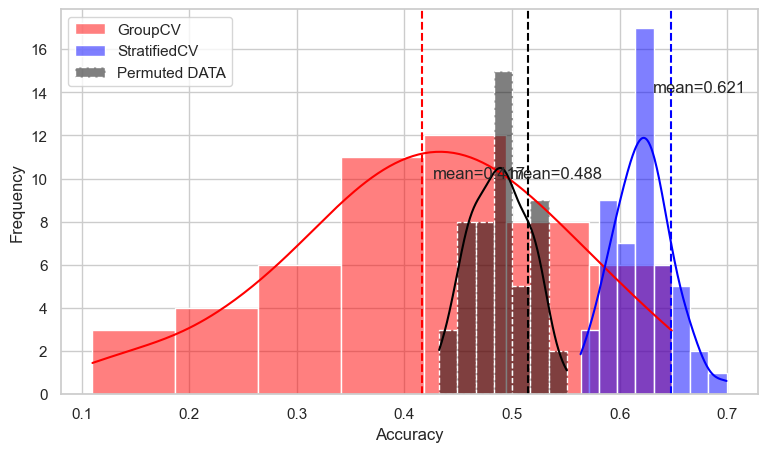

In [196]:
# visualizations
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(9, 5))
sns.histplot(scores_g, kde=True, legend=True, color='red', label='GroupCV')
sns.histplot(scores_s, kde=True, legend=True, color='blue', label='StratifiedCV')
sns.histplot(scores_sh, kde=True, legend=True, color='black', label='Permuted DATA', linestyle='--')
# Add mean and std to the plot
plt.axvline(np.array(scores_g).mean(), color='red', linestyle='--')
plt.axvline(np.array(scores_s).mean() + np.array(scores_s).std(), color='blue', linestyle='--')
plt.axvline(np.array(scores_sh).mean() + np.array(scores_sh).std(), color='black', linestyle='--')
# add text mean
plt.text(np.array(scores_g).mean() + 0.01, 10, f'mean={np.array(scores_g).mean():.3f}', fontsize=12)
plt.text(np.array(scores_s).mean() + 0.01, 14, f'mean={np.array(scores_s).mean():.3f}', fontsize=12)
plt.text(np.array(scores_sh).mean() + 0.01, 10, f'mean={np.array(scores_sh).mean():.3f}', fontsize=12)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

### Notes
using the final output of the critic, results in a highest accuracy!! (could not replicate this result!)
it seems that the conv layers of the critic are responsible for getting similar outputs from different layers.


## DEBUG

In [21]:
from keras import layers
feature = 8
kernel_size = 7
negative_slope = 0.2
input_shape = (1024, 1)

generator = keras.Sequential([
    keras.Input(shape=(latent_dim,)),
    layers.Dense(128),
    layers.LeakyReLU(negative_slope=negative_slope),
    layers.Dense(256),
    layers.LeakyReLU(negative_slope=negative_slope),
    layers.Reshape((256 // 1, 1)),
    layers.UpSampling1D(size=2),
    layers.Conv1D(16, 3, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(negative_slope=negative_slope),
    layers.UpSampling1D(size=2),
    layers.Conv1D(32, 5, padding='same'),
    layers.BatchNormalization(),
    layers.LeakyReLU(negative_slope=negative_slope),
    layers.Conv1D(1, 7, padding='same'),
    layers.Reshape(input_shape)
], name='generator')

generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_72 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_73 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_36 (Reshape)            │ (None, 256, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_36 (UpSampling1D) │ (None, 512, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_54 (Conv1D)              │ (None, 512, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 512, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_74 (LeakyReLU)      │ (None, 512, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_37 (UpSampling1D) │ (None, 1024, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 1024, 32)       │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 1024, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_75 (LeakyReLU)      │ (None, 1024, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_56 (Conv1D)              │ (None, 1024, 1)        │           225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_37 (Reshape)            │ (None, 1024, 1)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,417 (173.50 KB)

 Trainable params: 44,321 (173.13 KB)

 Non-trainable params: 96 (384.00 B)